In [1]:
import numpy as np
import pandas as pd
from nilearn import image as nli
from nilearn import plotting as nl_plotting
from nilearn.maskers import NiftiMapsMasker
import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure


## 1 - Import data

In [2]:
from pathlib import Path
import glob
import seaborn as sns

In [3]:
root_folder = Path().resolve()

In [4]:
data_folder = root_folder / '__data'
run = '01'
print(f"Data folder : {data_folder}")

Data folder : C:\Users\Mathis\Desktop\Bahut\M2\Semestre 1\Time Series\Projet final\BOLD5000\From Openeuro\__data


In [5]:
ROIs_maps_filename = data_folder / f'subCSI1_ROIs_maps.nii.gz' # depend of the run ?

if not ROIs_maps_filename.exists():
    brainmask_files = sorted(glob.glob(str(data_folder / 'sub1ROIs' / 'subCSI1')+'*_brainmask*'))  # depend of the run ?
    sum_img = nli.load_img(brainmask_files[0])
    atlas_files = sorted(glob.glob(str(data_folder / 'sub1ROIs' / 'subCSI1')+'*_mask*')) # to sort ?
    print(f"There are {len(atlas_files)} ROIs")
    maps = image.concat_imgs(atlas_files)



    print(f"Size of images : {maps.shape}")
    print(f"Labels values: {np.unique(maps.get_fdata())}")
    maps.to_filename(str(ROIs_maps_filename))

ROIs_labels = np.loadtxt(data_folder / 'ROIs_labels.txt', dtype=str)
print(ROIs_labels)

['LHEarlyVis' 'LHLOC' 'LHOPA' 'LHPPA' 'LHRSC' 'RHEarlyVis' 'RHLOC' 'RHOPA'
 'RHPPA' 'RHRSC']


In [6]:
img_path = root_folder / 'Cloned/ds001499/derivatives/fmriprep/sub-CSI1/ses-01/func'

In [7]:
confounds_filename = data_folder / 'sub1_ses01_run01_confounds.tsv'
confounds_df = pd.read_csv(confounds_filename, sep='\t')
print(confounds_df.columns)
confounds_df.bfill(inplace=True)
print(confounds_df.shape)

Index(['CSF', 'WhiteMatter', 'GlobalSignal', 'stdDVARS', 'non-stdDVARS',
       'vx-wisestdDVARS', 'FramewiseDisplacement', 'tCompCor00', 'tCompCor01',
       'tCompCor02', 'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00',
       'aCompCor01', 'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05',
       'Cosine00', 'Cosine01', 'Cosine02', 'Cosine03', 'Cosine04',
       'NonSteadyStateOutlier00', 'X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ'],
      dtype='object')
(194, 31)


In [8]:
img_files = [str(img_path / 'sub-CSI1_ses-01_task-5000scenes_run-0{}_bold_space-T1w_preproc.nii.gz').format(i) for i in range(1,7)]

ims = [nli.load_img(img_filename) for img_filename in img_files]
print("number of images : ", len(ims))
print("dimension of each image : ", np.shape(ims[5]))

number of images :  6
dimension of each image :  (71, 89, 72, 194)


In [9]:
time_series_filenames = [data_folder / 'sub1_ses01_run0{}_time_series.npy'.format(i) for i in range(6)]

all_time_series = []

for img_filename in img_files :
    masker = NiftiMapsMasker(maps_img=ROIs_maps_filename,
                            standardize='zscore_sample',
                            standardize_confounds='zscore_sample',
                            )
    time_series = masker.fit_transform(img_filename, confounds=confounds_df)
    all_time_series.append(time_series)
    print(time_series.shape)

(194, 10)
(194, 10)
(194, 10)
(194, 10)
(194, 10)
(194, 10)


Visualize the 10 1D-time series associated to the first image.

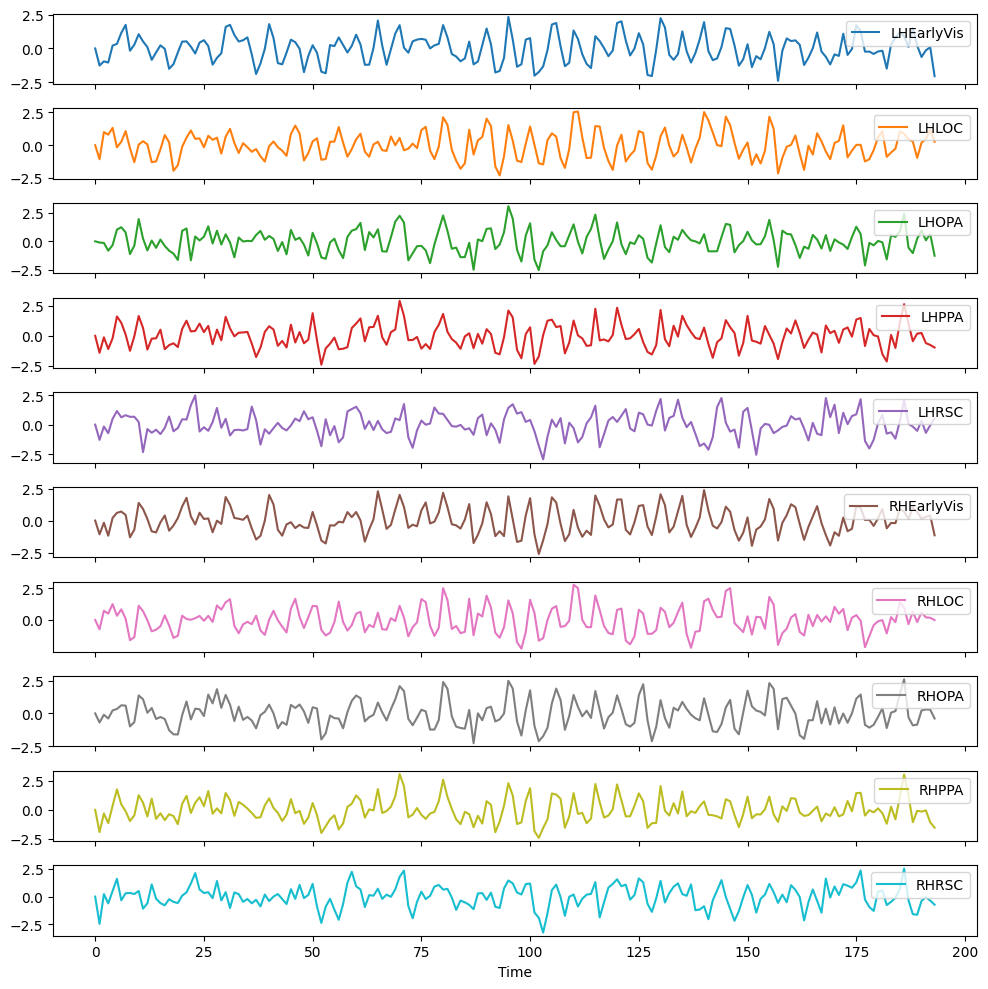

In [10]:
color_brain_regions = sns.color_palette(n_colors=10)
fig, ax = plt.subplots(10, 1, figsize=(10, 10))
for i in range(10):
    ax[i].plot(all_time_series[0][:, i], color=color_brain_regions[i], label=f'{ROIs_labels[i]}')
    ax[i].legend(loc='upper right')
    if i != 9:
        ax[i].tick_params('x', labelbottom=False)

ax[i].set_xlabel('Time')
fig.tight_layout()
plt.show()

# fig.savefig(figure_folder / 'plot_time_series.png')

## 2 - Compute connectivity

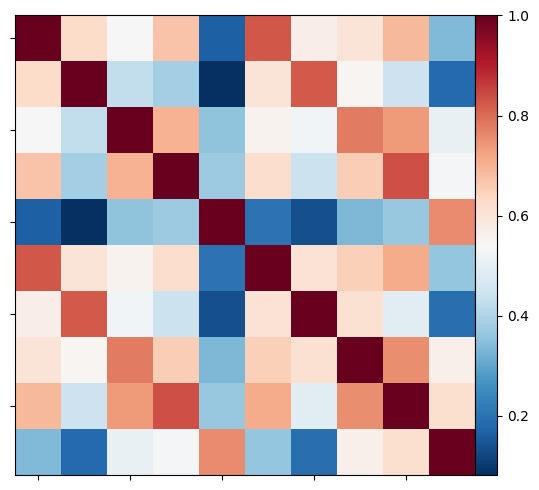

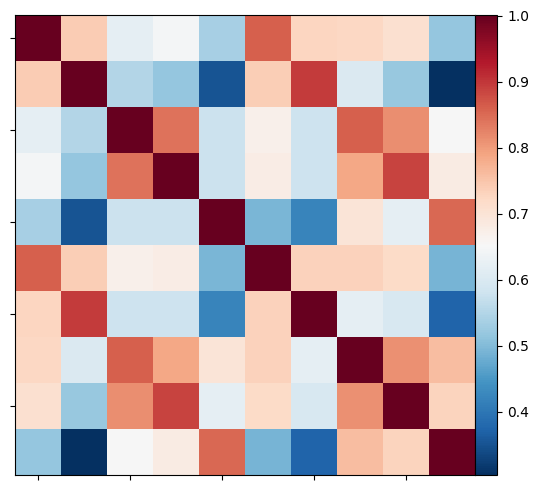

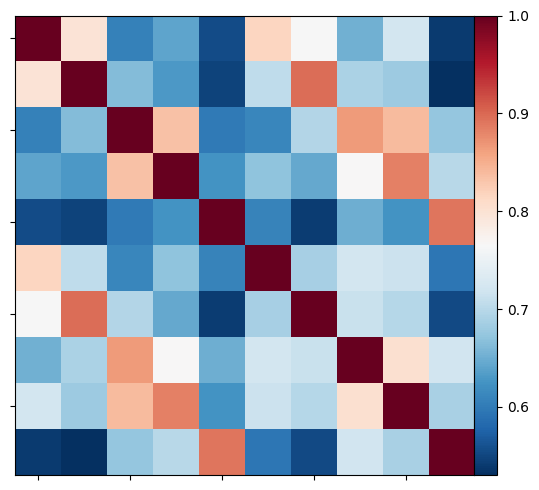

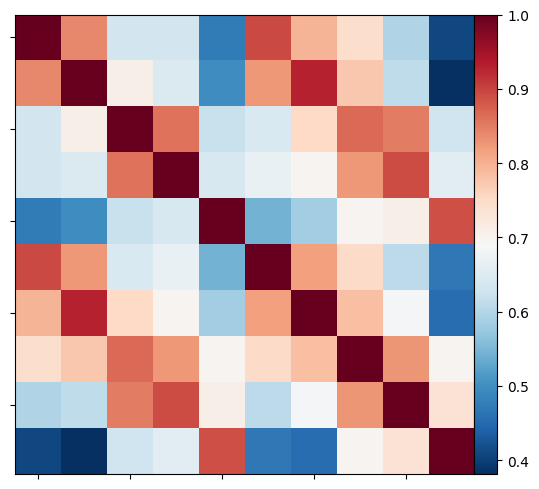

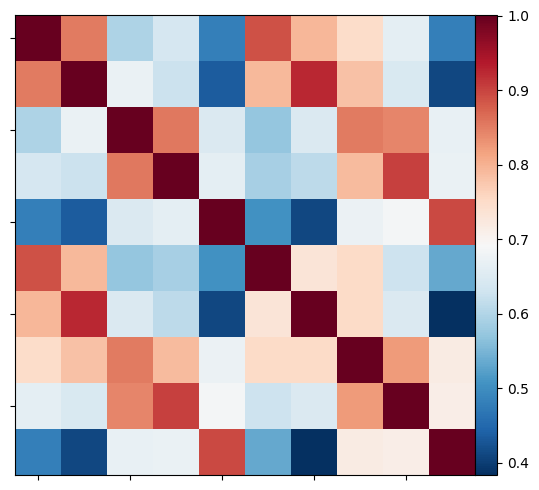

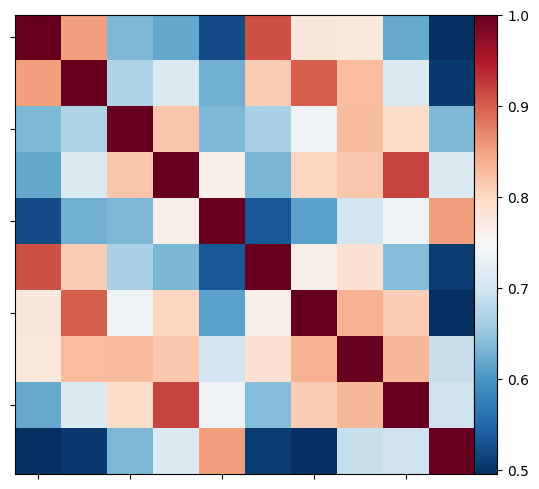

In [11]:
correlation_matrices = []
for time_series in all_time_series :
    correlation_measure = ConnectivityMeasure(
        kind="correlation",
        standardize="zscore_sample",
    )
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    correlation_matrices.append(correlation_matrix)
    nl_plotting.plot_matrix(correlation_matrix)
plt.show()

Compute brain coordinates of each region

In [12]:
coordinates = nl_plotting.find_probabilistic_atlas_cut_coords(ROIs_maps_filename)
print(coordinates.shape)

(10, 3)


Plot each of the 6 brain graphs

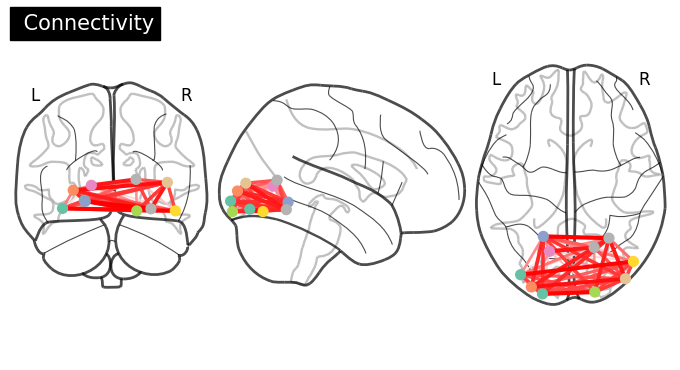

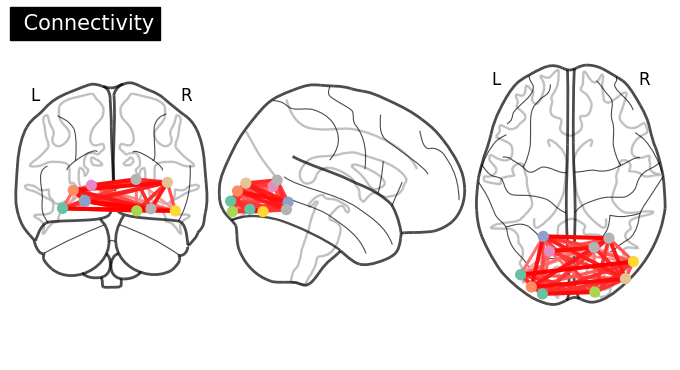

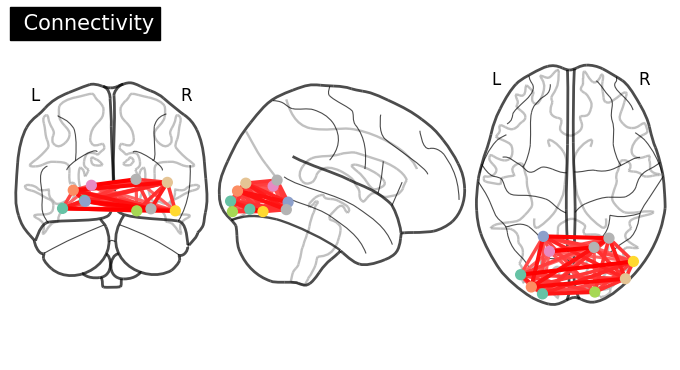

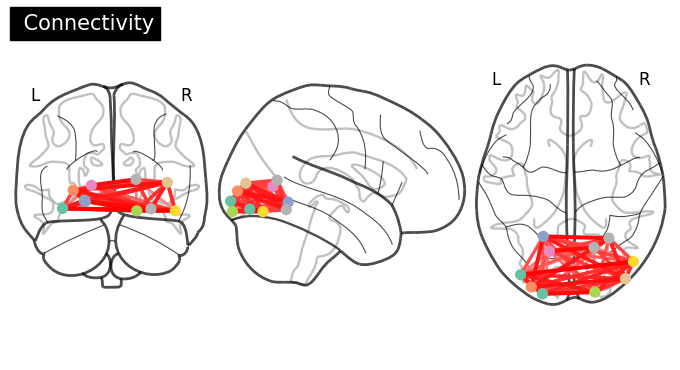

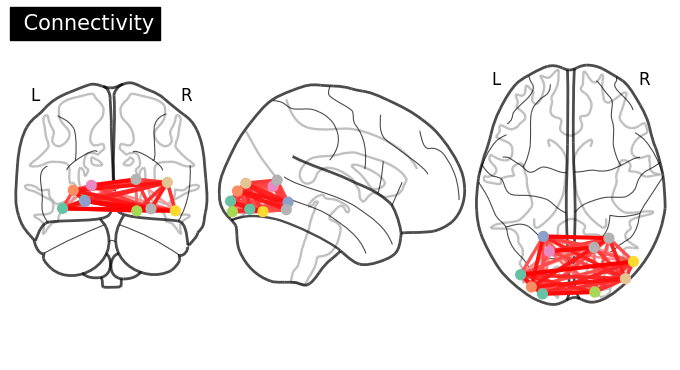

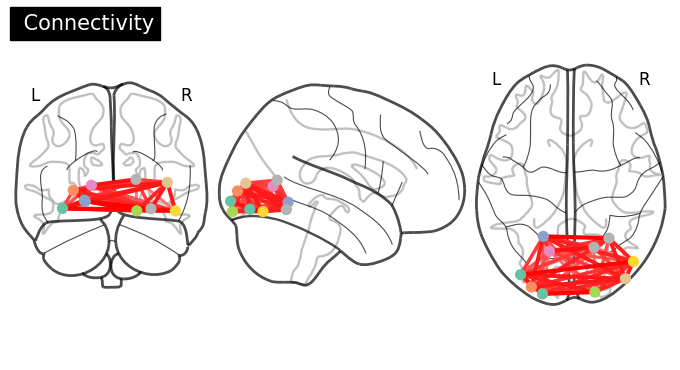

In [13]:
for correlation_matrix in correlation_matrices :
    nl_plotting.plot_connectome(correlation_matrix,
                             coordinates,
                            #  edge_threshold="100%",
                             title=' Connectivity')
plt.show()

We are left with 6 connectivity matrices. But we want to compute a single graph. Thus, in the following section, we average the connectivity matrices.

## 3 - Define pyGSP objects

In [14]:
from pygsp import graphs

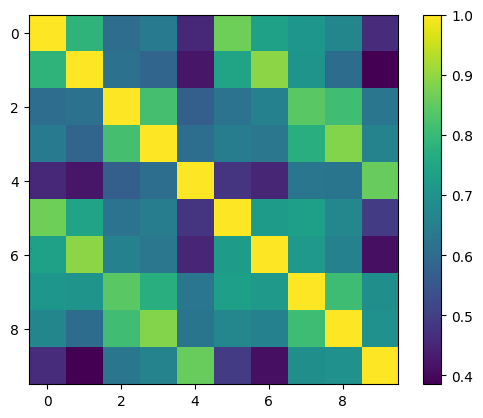

In [15]:
average_correlation_matrix = np.mean(correlation_matrices, axis=0)

plt.imshow(average_correlation_matrix)
plt.colorbar()
plt.show()

We define the graph

In [16]:
np.fill_diagonal(average_correlation_matrix, 0)
G = graphs.Graph(average_correlation_matrix)
G.compute_fourier_basis()

We visualize the eigenvalues of the laplacian matrix.

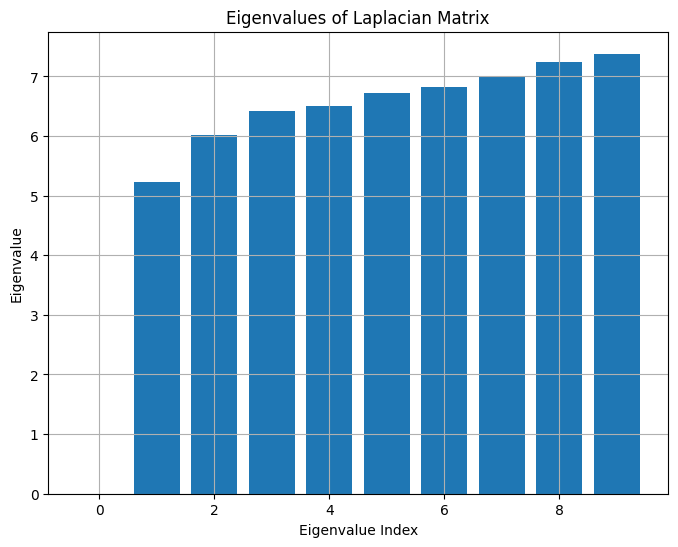

In [17]:
# Plotting the bar diagram of sorted eigenvalues
plt.figure(figsize=(8, 6))
plt.bar(np.arange(G.e.shape[0]), G.e)
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of Laplacian Matrix')
plt.grid(True)
plt.show()

## 4 - Compute Fourier Transform of a graph signal

In [18]:
Xs = []
for time_series in all_time_series :
    X = time_series.T
    Xs.append(X)

In [19]:
def plot_stems (X_tild) :
    plt.figure(figsize=(8, 6))
    markerline, stemlines, baseline = plt.stem(np.arange(G.e.shape[0]), np.square(X_tild), linefmt='-', markerfmt='o', basefmt=' ')
    plt.setp(stemlines, linestyle='-')  # Change stem line properties
    plt.setp(markerline, markersize=8)  # Change marker properties
    plt.setp(baseline, visible=False)  # Hide the baseline
    plt.xlabel('Eigenvalue Index')
    plt.ylabel('Norm of Fourier Coefficients')
    plt.title('Norm of Fourier Coefficients Associated with Eigenvalues')
    plt.grid(True)

In [20]:
X0 = Xs[0]
X0_tilds = G.U.T@X0[:]

In [21]:
X0_tilds.shape

(10, 194)

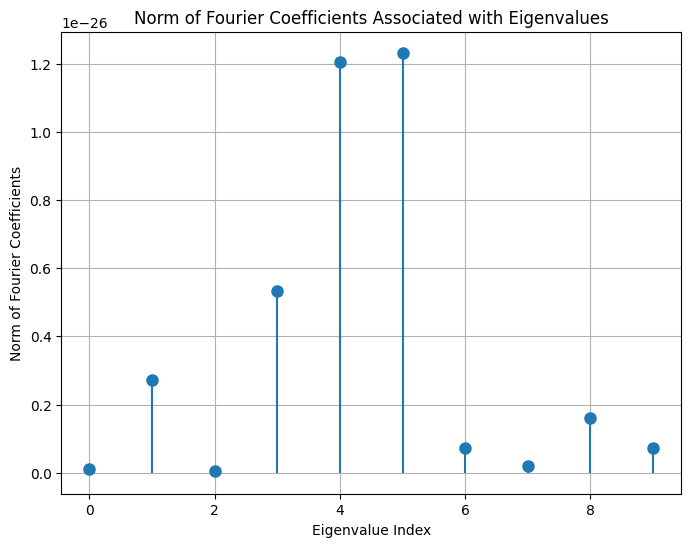

In [22]:
plot_stems(X0_tilds[:,0])

In the graph bellow, we visualize the 6th Fourier coefficients of with brain images from the first run.

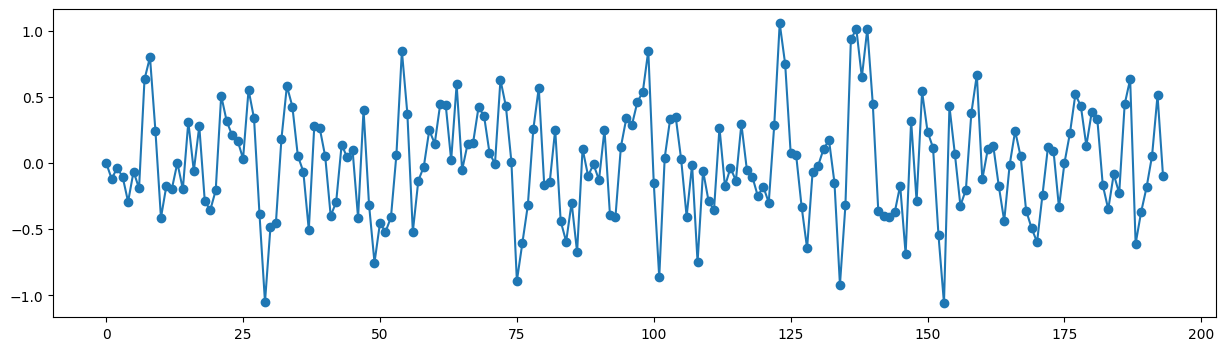

In [23]:
plt.figure(figsize=(15, 4))
plt.scatter(np.arange(X0_tilds.shape[-1]),X0_tilds[5])
plt.plot(X0_tilds[5])

In [24]:
events_path = "Cloned/ds001499/sub-CSI1/ses-01/func"

In [25]:
all_events = [pd.read_table(events_path + '/sub-CSI1_ses-01_task-5000scenes_run-0{}_events.tsv'.format(i), sep='\t') for i in range(1,7)]

In [26]:
all_events[0]

,onset,duration,Subj,Sess,Run,Trial,ImgName,ImgType,StimOn(s),StimOff(s),Response,RT,stim_file
0,6.0367,0.9678,1,1,1,1,n01930112_19568.JPEG,imagenet,6.0367,7.0045,2,3.6309,n01930112_19568.JPEG
1,16.0122,0.9837,1,1,1,2,n03733281_29214.JPEG,imagenet,16.0122,16.9959,2,4.2031,n03733281_29214.JPEG
2,26.0037,1.0009,1,1,1,3,n07695742_5848.JPEG,imagenet,26.0037,27.0046,1,1.8948,n07695742_5848.JPEG
3,36.0121,0.9844,1,1,1,4,COCO_train2014_000000420713.jpg,coco,36.0121,36.9965,1,2.4701,COCO_train2014_000000420713.jpg
4,46.0038,1.0008,1,1,1,5,COCO_train2014_000000488558.jpg,coco,46.0038,47.0046,1,2.8065,COCO_train2014_000000488558.jpg
5,56.0122,0.9843,1,1,1,6,n01917289_1429.JPEG,imagenet,56.0122,56.9965,1,3.6220,n01917289_1429.JPEG
6,66.0040,1.0008,1,1,1,7,n02108551_26574.JPEG,imagenet,66.0040,67.0047,1,1.4464,n02108551_26574.JPEG
7,75.9953,1.0011,1,1,1,8,COCO_train2014_000000029114.jpg,coco,75.9953,76.9964,1,1.8382,COCO_train2014_000000029114.jpg
8,86.0041,1.0007,1,1,1,9,n02111277_28582.JPEG,imagenet,86.0041,87.0048,1,1.9422,n02111277_28582.JPEG
9,95.9955,1.0011,1,1,1,10,concert5.jpg,scenes,95.9955,96.9965,3,2.2059,concert5.jpg


In [27]:
all_onsets = [events.onset.values/388*194 for events in all_events]

In the graph bellow, the orange bars represent the time at which a new image is show to the sibject.

[None]

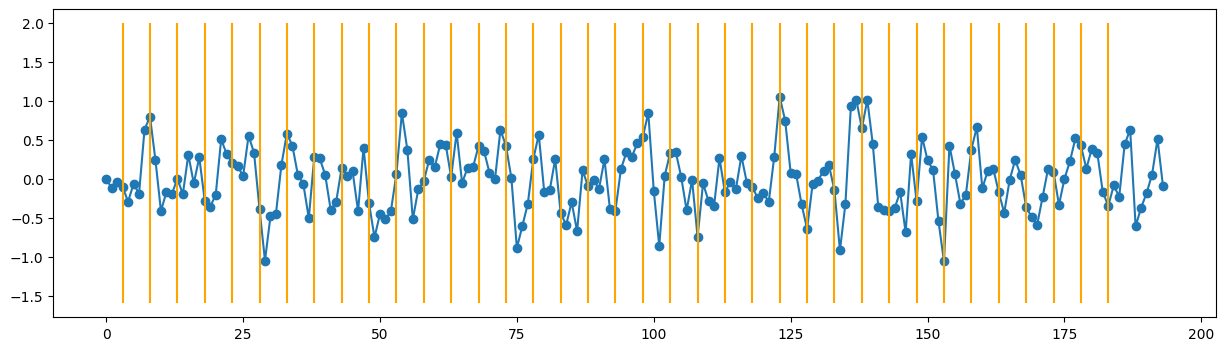

In [28]:
plt.figure(figsize=(15, 4))
plt.scatter(np.arange(X0_tilds.shape[-1]),X0_tilds[5])
plt.plot(X0_tilds[5])

markerline, stemlines, baseline = plt.stem(all_onsets[0], 2*np.ones(37), linefmt='orange', markerfmt=' ', basefmt=' ', bottom=-1.6)
plt.setp(stemlines, linestyle='-')  # Change stem line properties
plt.setp(markerline, markersize=8)

## 5 - Load labels

In [29]:
y_builders = [events[['onset','Response']].values for events in all_events]

In [30]:
def find_label(i,y_builder):
    target_time = i / 194 * 388
    j = 0
    while j<37 and target_time >= y_builder[j,0]:
        j +=1
    return y_builder[j-1,1]

In [31]:
def find_first_i(first_time):
    i = 0
    while i < first_time * 194 / 388:
        i += 1
    return i

In [32]:
ys = []
first_is = []
for y_builder in y_builders :
    first_i = find_first_i(y_builder[0,0])
    first_is.append(first_i)
    l = 187 - first_i+1
    y = np.zeros(l)
    for i in range(first_i-1,187) :
        y[i-first_i+1] = find_label(i,y_builder)
    ys.append(y)

In [33]:
ys[0].shape

(184,)

In [34]:
adjusted_raw_Xs = []
for first_i in first_is :
    adjusted_raw_X = np.square(X[:,first_i-1:187])
    adjusted_raw_Xs.append(adjusted_raw_X)

## 6 - Sklearn on raw activations (pas de Fourier)

In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score,accuracy_score
from sklearn.model_selection import train_test_split

In [36]:
combined_raw_X = np.hstack(adjusted_raw_Xs).T
combined_y = np.hstack(ys)

In [37]:
combined_raw_X.shape

(1104, 10)

In [38]:
raw_X_train, raw_X_test, raw_y_train, raw_y_test = train_test_split(combined_raw_X, combined_y, test_size=0.2, random_state=42)

In [39]:
raw_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

In [40]:
raw_clf.fit(raw_X_train, raw_y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [41]:
raw_y_pred = raw_clf.predict(raw_X_test)

In [42]:
balanced_accuracy_score(raw_y_test,raw_y_pred)

0.33741913517194416

## 7 - Sklearn on processed activations (normes de coeffs de Fourier en input)

In [43]:
all_X_tilds = [G.U.T@X for X in Xs]

In [44]:
Xs_pro = []
for X_tilds,first_i in zip(all_X_tilds,first_is) :
    X_pro = np.square(X_tilds)[:,first_i-1:187]
    Xs_pro.append(X_pro)

In [45]:
combined_X_pro = np.hstack(Xs_pro).T

In [46]:
pro_X_train, pro_X_test, pro_y_train, pro_y_test = train_test_split(combined_X_pro, combined_y, test_size=0.2, random_state=42)

In [47]:
pro_clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 10), random_state=1)

In [50]:
pro_clf.fit(pro_X_train, pro_y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 10), random_state=1,
              solver='lbfgs')

In [51]:
pro_y_pred = pro_clf.predict(pro_X_test)

In [52]:
balanced_accuracy_score(pro_y_test,pro_y_pred)

0.28864487572352737

## 8 - Idem with another model

In [53]:
from sklearn.ensemble import HistGradientBoostingClassifier as HGBC

In [54]:
HGBC_model = HGBC()

In [55]:
HGBC_model.fit(pro_X_train,pro_y_train)

HistGradientBoostingClassifier()

In [56]:
y_pred_train_pro_HGCB = HGBC_model.predict(pro_X_train)

In [57]:
balanced_accuracy_score(pro_y_train,y_pred_train_pro_HGCB)

1.0

In [58]:
y_pred_test_pro_HGCB = HGBC_model.predict(pro_X_test)

In [59]:
balanced_accuracy_score(pro_y_test,y_pred_test_pro_HGCB)

0.3235869935308137

## 9 - Dictionnary learning

In [60]:
from alphacsc import learn_d_z

In [61]:
def plot_CDL(signal, Z, D, figsize=(15, 10)):
    """Plot the learned dictionary `D` and the associated sparse codes `Z`.

    `signal` is an univariate signal of shape (n_samples,) or (n_samples, 1).
    """
    (atom_length, n_atoms) = np.shape(D)
    plt.figure(figsize=figsize)
    plt.subplot(n_atoms + 1, 3, (2, 3))
    plt.plot(signal)
    for i in range(n_atoms):
        plt.subplot(n_atoms + 1, 3, 3 * i + 4)
        plt.plot(D[:, i])
        plt.subplot(n_atoms + 1, 3, (3 * i + 5, 3 * i + 6))
        plt.plot(Z[:, i])
        plt.ylim((np.min(Z), np.max(Z)))

In [62]:
signal = X0_tilds[5]

In [63]:
# Parameters to change
n_atoms = 15  # K
atom_length = 4  # L (2000 pour 1 seconde)
penalty = 1  # lambda

In [64]:
%%time
# learning a dictionary and codes
pobj, _, d_hat, z_hat, _ = learn_d_z(
    X=signal[None,:],
    n_atoms=n_atoms,
    n_times_atom=atom_length,
    reg=penalty,
    n_iter=30,
    n_jobs=4,
    verbose=1)

V_0/30 .............................
CPU times: total: 46.9 ms
Wall time: 3.31 s


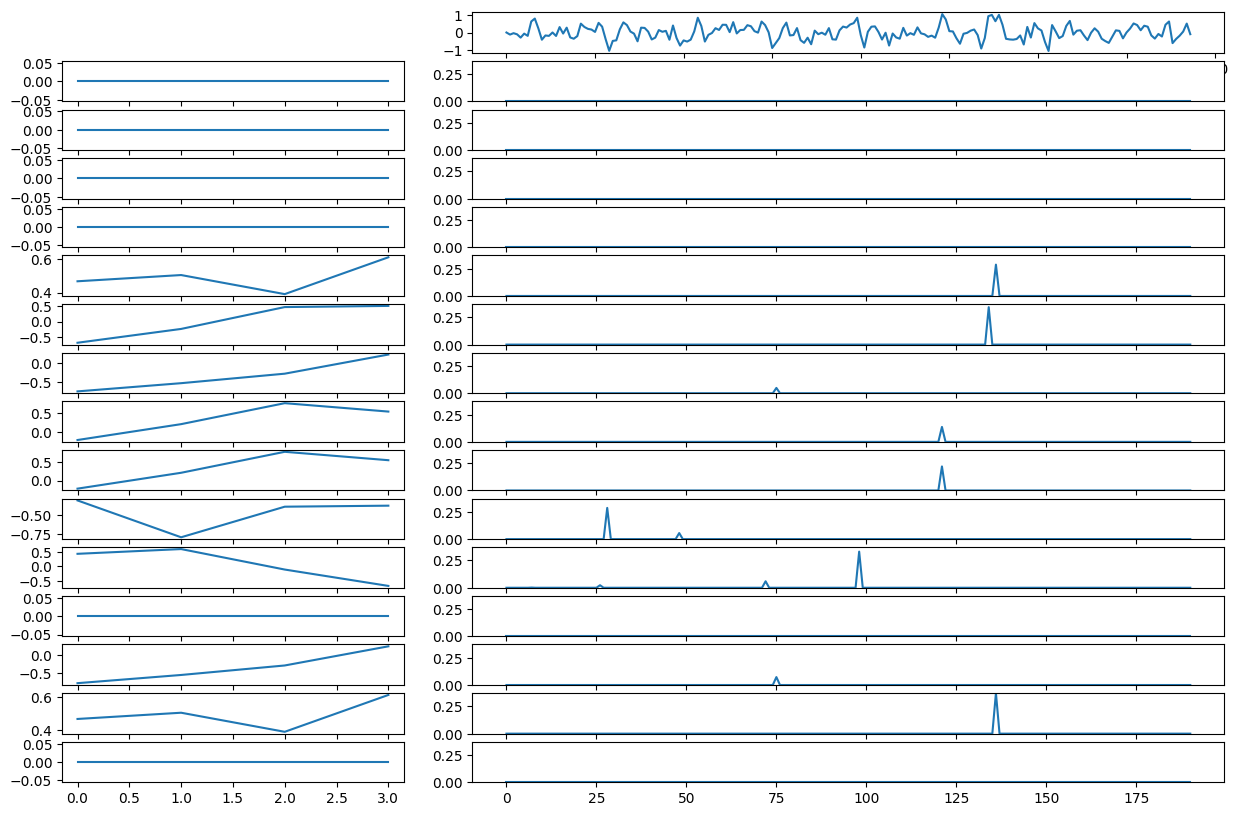

In [65]:
plot_CDL(signal, z_hat.T.squeeze(), d_hat.T.squeeze())